In [1]:
import sys
import os

import numpy as np
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt



# MNIST

* Fetch the **MNIST** dataset **Mixed National Institute of Standards and Technology**

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
mnist['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [5]:
X, y =mnist['data'],mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

* 70,000 images with 784 features each representing a 28x28 pixel grid with a pixel intensity ranging from 0 to 255.

In [7]:
len(X[0])

784

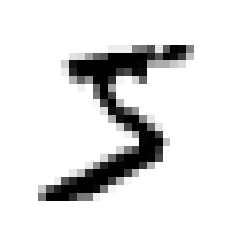

In [8]:
some_digit = X[0]#array representation of a number
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap=mpl.cm.binary)
plt.axis('off')

plt.show()

In [9]:
y[0]

'5'

In [10]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

* Setting aside our test set. In this dataset they were already gathered as being the last 10,000 observations.

In [11]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Training a Binary Classifier

We simplify the problem by focusing on a **binary classifier**, trying to detect whether it's a **5** or a **non-5** (2 classes).

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

* We start by training a Stochastic Gradient Descent (SGD) classifier.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

* We use it to detect images of the number 5

In [14]:
sgd_clf.predict([some_digit])

array([ True])

=> The classifier guesses that the image represents a 5.

# Performance measures

* Evaluating a classifier is trickier than evaluating a regressor.

## Measuring accuracy using Cross-Validation

### Stratified K-Folds

Performs stratified sampling to produce folds with representative ratio of each class.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


### Cross-Validation

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

* more than 95% accuracy on all folds

### Dumb Classifier

Classify as not-5 every single image

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

Confusion Matrix is a better way to evaluate the performance of a classifier. (count the number of times instances of class A are classified as class B).

* we need a set of predictions to compute the confusion matrix. We will use it on our train set to save the test one.

In [19]:
from sklearn.model_selection import cross_val_predict

#returns a set of predictions after performing K-folds cross-validation
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

In [20]:
len(y_train_pred)

60000

* Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row represents an **actual class** while each column represents a **predicted class**

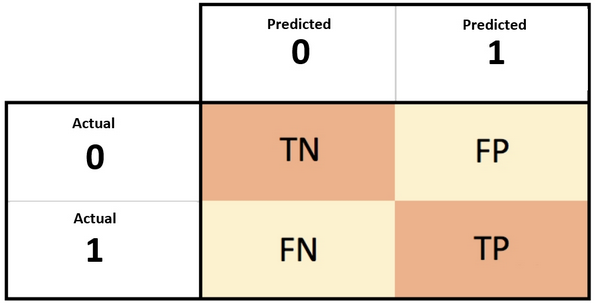

In [22]:
## Ipython image of confusion matrix
from IPython.display import Image 
Image("media\\matrix.png")

* First row considers non-5 images
    * 53892 correctly classified as non-5 (**T**rue **N**egatives)
    * The rest was wrongly classifeif as 5s (**F**alse **P**ositives)
    
* Second row considers 5 images
    * 1891 wrongly classified as non-5 (**F**alse **N**egatives)
    * 3530 correctly classified as 5s (**T**rue **P**ositives)

* A perfect classifier would have only True Positives and True Negatives

In [23]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision & Recall

* Accuracy of the positive predictions : **Precision**. Out of the total Positive predicted by the model, what is the % of actual positive results.

**Precision** answers the question : What is the proportion of positive identifications correctly guessed.

$Precision = \frac{TP}{TP+FP}$

TP : number of True Positives  
FP : number of False Positives

* Precision is used with another metric called **Recall** (**Sensitivity** or TPR for **True Positive Rate**)

**Recall** answers the question : What is the proportion of real positive results correctly identified.

$Recall = \frac{TP}{TP+FN}$

FN : Number of false Negatives

In [24]:
# precision score
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [25]:
# precision alternative
cm = confusion_matrix(y_train_5,y_train_pred)
cm[1,1] / (cm[0,1]+cm[1,1])

0.8370879772350012

In [26]:
# recall score
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
# recall alternative
cm[1,1] / (cm[1,1]+cm[1,0])

0.6511713705958311

* When the model claims an image represents 5, it is correct 83% of the time (Precision)
* The model detects 65% of the 5s (recall)

### F1 Score

We can combine **Precision** and  **Recall** in a single metric called the ${F}_{1}$ score. 
* ${F}_{1}$ is a **<i>harmonic mean</i>** of precision and recall, it's a mean that gives much more weight to low values.  
=> The classifier will only get a high ${F}_{1}$ if both recall and precision are high.

${F}_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 x \frac{precision * recall}{precision + Recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [28]:
# F1 Score in python
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [29]:
# F1 Score alternative
cm[1,1]/(cm[1,1] + (cm[1,0] + cm[0,1])/2)

0.7325171197343847

Increasing precision reduces recall and vice versa. This is known as **Precision/Recall Tradeoff**

## Precision vs Recall : Intuition

**Recall**  
Models need high recall when you need output-sensitive predictions. For example, predicting cancer or predicting terrorists needs a high recall, in other words, you need to cover false negatives as well. It is ok if a non-cancer tumor is flagged as cancerous but a cancerous tumor should not be labeled non-cancerous.

**Precision**  
Similarly, we need high precision in places such as recommendation engines, spam mail detection, etc. Where you don’t care about false negatives but focus more on true positives and false positives. It is ok if spam comes into the inbox folder but a really important mail shouldn’t go into the spam folder.

### Precision/Recall TradeOff

Scikit learn doesn't allow setting the threshold directly but guves access to the decision score used to predict the model.

todo : https://www.geeksforgeeks.org/ml-decision-function/

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* The image represents a **5**. The classifier detects it when the threshold is set to 0 but not when it's set to 8000.  

=> Increasing the threshold decreases the recall

* How to decide which threshold to use ?  


In [33]:
# get the scores of all instances using the cross_val_predict() with the decision function param
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')


In [34]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

* We compute precision and recall for all possible thresholds

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

* We plot precision and recall as functions of the threshold

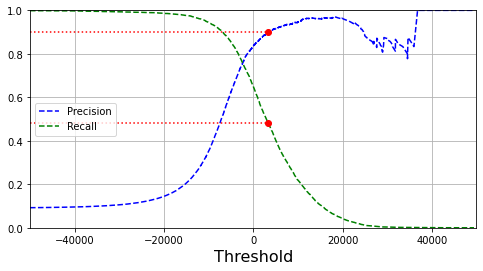

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label='Precision')
    plt.plot(thresholds, recalls[:-1],'g--',label='Recall')
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc='center left')
    plt.grid(True) 
    plt.ylim([0,1])
    plt.axis([-50000, 50000, 0, 1])
    
# draw a 90% intersection point
recall_90_precision = recalls[np.argmax(precisions >=0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision,threshold_90_precision],[0.9,0.9],'r:')
#draw the lines
plt.plot([-50000,threshold_90_precision],[0.9,0.9],'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
# draw the points
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro") 

* Precision curve can get bumpier cause the precision may go down when we raise the threshold.
* Recall can only can only go down with a higher threshold, hence the smooth curve

* Another way to select a good threshold value is by plotting precision against recall

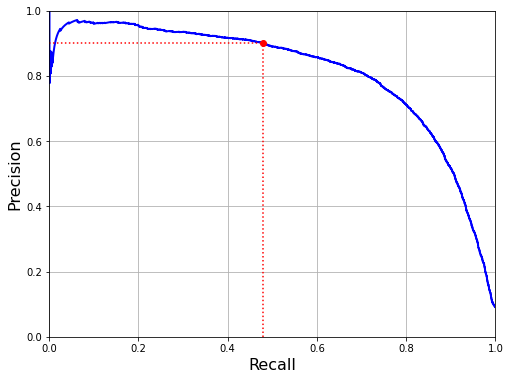

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions,"b-",linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0,1,0,1])# ???
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
# draw lines
plt.plot([recall_90_precision, recall_90_precision],[0.,0.9],'r:')
plt.plot([0.0,recall_90_precision],[0.9,0.9],'r:')
# draw the point
plt.plot([recall_90_precision],[0.9],'ro')


* Precision starts brutally sinking around 80% recall. The sweet spot would be around 60% depending on our needs.

Let's suppose we aim for a 90% precision, we identify the target threshold

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

We use this threshold to make predictions

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [40]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

* We get a 90% precision classifier. It is pretty easy to create a classifier with any precision, its just needs a high enough threshold.  
* A high precision classifier is not very useful if its recall is too low.

"If someone asks to reach for 99% precision, always ask at what recall ?"

### The ROC Curve

* The **Receiver Operating Characteristic (ROC)** is another common tool used with binary classifiers.  
* The **ROC Curve** plots the True Positive Rate TPR (Recall) against the Falase Positive Rate FPR.

FPR : ratio of negative instances incorrectly classified as Positive. it is equal to 1 - TNR.  
TNR **<i>(Specificity)</i>** : ratio of negative instances correclty classified as negative.

* ROC plots sensitivity (recall) versus 1 - specificity

* To plot the ROC Curve we need to compute the TPR and FRP for various threshold values

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

* Then we plot the FPR against the TPR

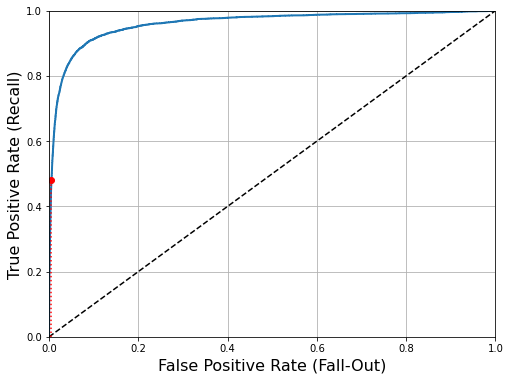

In [43]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')# dashed diagonal
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate (Fall-Out)',fontsize=16)
    plt.ylabel('True Positive Rate (Recall)',fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90],[0.,recall_90_precision],'r:')
plt.plot([0.0,fpr_90],[recall_90_precision,recall_90_precision],"r:")
plt.plot([fpr_90],[recall_90_precision],"ro")#plot the red point

plt.show()

* The dotted line represents the ROC curve of a purely random classifier.  
A good classifier stays far away from the line. (top left corner)

**TRADE OFF :** The higher the recall (TPR), the more false positives (FPR)  the classifier produces.

### AUC 

**Area Under the Curve** is a way to compare classifiers.  
* Perfect classifier will have a ROC AUC equal to 1
* Purely random classifier will have a ROC AUC equal to 0.5

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

#### Precision/Recall vs ROC AUC

We should prefer the PR Curve when we care more about the false positives than the false negatives (rare positives) otherwise we use the ROC AUC.

#### ROC AUC : SGDClassifier vs RandomForest

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method='predict_proba')

In [46]:
y_scores_forest = y_proba_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

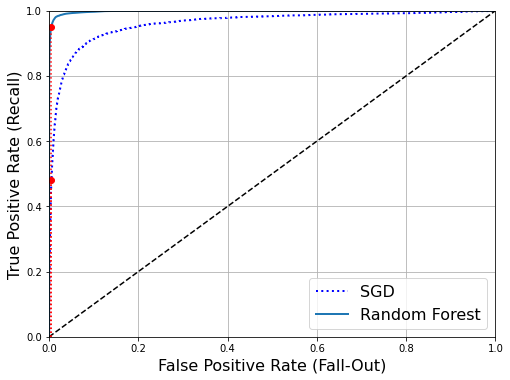

In [47]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr,"b:",linewidth=2,label="SGD")# fpr/tpr
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")# ROC curve line

# 90 precision for SGDClassifier 
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

# 90 precision for Random Forest
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

We can clearly notice that the Random Forest Curve is much closer to the top left thant the SGDClassifier.  
- ROC AUC Random Forest : 0.998
- ROC AUC SGDC : 0.960

In [49]:
# Random Forest Precision 
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### How to Train Binary Classifiers Review :

* Choose the appropriate metric
* Evaluate classifier using cross validation
* Select the precision/recall tradeoff that fits the need
* Compare various models using ROC curves and ROC AUC scores


# Multiclass Classification

!!! OvA x OvO

In [51]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit]) # should be 5

array([3], dtype=uint8)

Training on the original target classes (from 0 to 9).  
Implicitly, Scikit-learn trained 10 binary classifiers, got the decision scores and selected the one with the highest score.

In [52]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

* We choose the one with the highest score 

In [53]:
np.argmax(some_digit_scores)# it should be 5

3

* When a classifier is trained, it stores the list of target classes in its **classes_** attribute ordered by value

In [54]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### Forcing Scikitlearn to use OvO or OvA

* simply by creating an instance and passing a binary classifier.

In [55]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
len(ovo_clf.estimators_)

45

* Random Forest do not need to run OvA or OvO cause it can directly classify instances into multiple classes.

In [57]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [58]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

The classifier is confident at 90% that some digit is a "5".  
It is confident at 1% that it is a "2" and 8% that it is a "3"

#### Evaluating the Classifiers

In [59]:
# takes time to run
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

With more than 85% accuracy on all folds it scores decent. But it can get better by scaling the inputs.

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

With scaling we can increase the accuracy to more than 89%

# Error Analysis

Improving a model by analyzing the errors it makes.

* Looking at the confusion matrix

In [61]:
# takes time to load
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train ,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

* Image representation of the confusion matrix

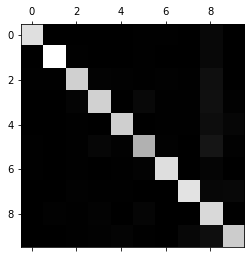

In [62]:
plt.matshow(conf_mx, cmap= plt.cm.gray)

* Error rate by divding each value in the confusion matrix by the number of images in the corresponding class.

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

* We fill the diagonals with zeros to keep only the errors

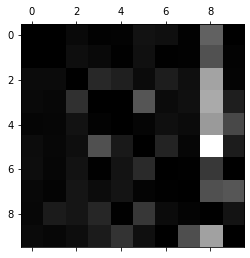

In [64]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)


* The brightness for the columns 8 and 9 tells us that many images gets misclassified as 8s and 9s.
* Rows for 8s and 9s are also quite bright meaning that they get confused for other digits.
* Row 1 is pretty dark, implying that it gets mostly correcty classified
* Erros are not symetrical a there are more 5s misclassified as 8 than the other way around.

Confusion matrix gives useful insights on how to improve the classifier :
* improve the classification of 8s and 9s
* fix the 3/5 confusion
This can be done by:
- introducing more training data 
- help with new features (closed loops identification algorithm)
- preprocess the images (Scikit-Image, Pillow, OpenCV)

#### Individual errors analysis

In [65]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

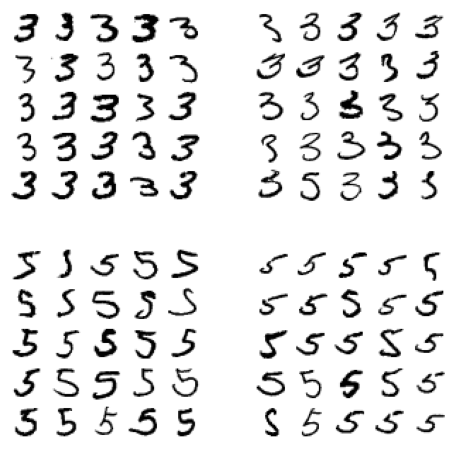

In [66]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

* The 2 blocks on the left show digits classified as 3s.
* The 2 blocks on the right show digits classified as 5s

The reason for the so many misclassification is to be found within the SGDClassifier. SGDC is a linear model assigning weights per class to each pixel. 3s and 5s only differ by a few pixels which leads to such confusion.

# Multilabel Classification 

It is used when there are two or more classes and the data we want to classify may belong to none of the classes or all of them at the same time, e.g. to classify which traffic signs are contained on an image.

* Multilabel containing **large numbers (7,8,9)** and **odd numbers**

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel# large and odd numbers labels

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

* Training a mutlilabel knn classifier

In [69]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

* Make a prediction

In [73]:
# ([some_digit]) : image of 5
knn_clf.predict([some_digit])

array([[False,  True]])